In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import skimage.feature
import pandas as pd
import random
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.datasets import mnist
%matplotlib inline

Using TensorFlow backend.


In [3]:
# Read coordinates from files
sealions_df_train = pd.read_csv('./sealions_train.csv', dtype={"coord_x": int, "coord_y": int, "class": str, "filename": str})
sealions_df_test = pd.read_csv('./sealions_test.csv', dtype={"coord_x": int, "coord_y": int, "class": str, "filename": str})
empty_df_train = pd.read_csv('./empty_train.csv', dtype={"coord_x": int, "coord_y": int, "filename": str})
empty_df_test = pd.read_csv('./empty_test.csv', dtype={"coord_x": int, "coord_y": int, "filename": str})

file_names_sea_lions_train = sealions_df_train.filename.unique()
file_names_sea_lions_test = sealions_df_test.filename.unique()
file_names_background_train = empty_df_train.filename.unique()
file_names_background_test = empty_df_test.filename.unique()

# Create global variable for data sets
data_set_sea_lions_train = []
data_set_sea_lions_test = []
data_set_background_train = []
data_set_background_test = []

# Use a random seed
random.seed(42)

In [4]:
# Load images and extract 96x96 patches for sea lions
def extract_sea_lions(file_names, data_set, sea_lions_df):
    for file in file_names:
        image = cv2.imread("./kaggle_sea_lions/Train/" + file)
        df = sea_lions_df[sea_lions_df['filename'] == file]
        for row in df.iterrows():
            x = row[1]['coord_x']
            y = row[1]['coord_y']
            if x < 48:
                x = 0
            elif x > len(image[0]) - 48:
                x = len(image[0]) - 96
            else:
                x = x - 48
            if y < 48:
                y = 0
            elif y > len(image) - 48:
                y = len(image) - 96
            else:
                y = y - 48
            patch = image[y:y+96, x:x+96, :]
            data_set.append(list((patch, "sea lion")))

In [5]:
# Load images and extract 96x96 patches for background
def extract_background(file_names, data_set, empty_df):
    for file in file_names:
        image = cv2.imread("./kaggle_sea_lions/Train/" + file)
        df = empty_df[empty_df['filename'] == file]
        for row in df.iterrows():
            x = row[1]['coord_x']
            y = row[1]['coord_y']
            patch = image[y-48:y+48, x-48:x+48, :]
            data_set.append(list((patch, "background")))

In [6]:
# Extract patches
extract_sea_lions(file_names_sea_lions_train, data_set_sea_lions_train, sealions_df_train)
extract_sea_lions(file_names_sea_lions_test, data_set_sea_lions_test, sealions_df_test)
extract_background(file_names_background_train, data_set_background_train, empty_df_train)
extract_background(file_names_background_test, data_set_background_test, empty_df_test)

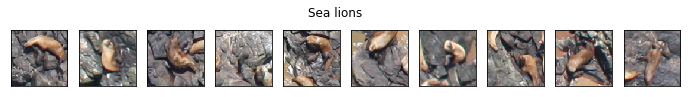

In [7]:
# Display sea lions train samples
tmp_disp = random.sample(data_set_sea_lions_train, 10)
f, ax = plt.subplots(1, 10, figsize=(12, 1.5))
f.suptitle("Sea lions")
axes = ax.flatten()
i = 0
for a in axes:
    a.set_xticks([])
    a.set_yticks([])
    a.imshow(cv2.cvtColor(tmp_disp[i][0], cv2.COLOR_BGR2RGB))
    i = i+1

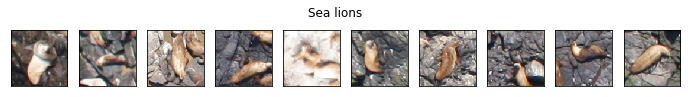

In [8]:
# Display sea lions test samples
tmp_disp = random.sample(data_set_sea_lions_test, 10)
f, ax = plt.subplots(1, 10, figsize=(12, 1.5))
f.suptitle("Sea lions")
axes = ax.flatten()
i = 0
for a in axes:
    a.set_xticks([])
    a.set_yticks([])
    a.imshow(cv2.cvtColor(tmp_disp[i][0], cv2.COLOR_BGR2RGB))
    i = i+1

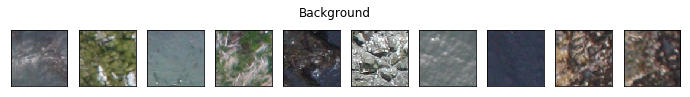

In [9]:
# Display background train samples
tmp_disp = random.sample(data_set_background_train, 10)
f, ax = plt.subplots(1, 10, figsize=(12, 1.5))
f.suptitle("Background")
axes = ax.flatten()
i = 0
for a in axes:
    a.set_xticks([])
    a.set_yticks([])
    a.imshow(cv2.cvtColor(tmp_disp[i][0], cv2.COLOR_BGR2RGB))
    i = i+1

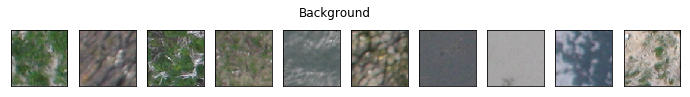

In [10]:
# Display background test samples
tmp_disp = random.sample(data_set_background_test, 10)
f, ax = plt.subplots(1, 10, figsize=(12, 1.5))
f.suptitle("Background")
axes = ax.flatten()
i = 0
for a in axes:
    a.set_xticks([])
    a.set_yticks([])
    a.imshow(cv2.cvtColor(tmp_disp[i][0], cv2.COLOR_BGR2RGB))
    i = i+1

In [22]:
# Build train set
train_set = data_set_sea_lions_train + data_set_background_train
random.shuffle(train_set)
X_train = []
Y_train = []
for data in train_set:
    X_train.append(data[0])
    if data[1] == "sea lion":
        Y_train.append([1, 0])
    elif data[1] == "background":
        Y_train.append([0, 1])
X_train = np.array(X_train)
Y_train = np.array(Y_train)

# Build test set
test_set = data_set_sea_lions_test + data_set_background_test
random.shuffle(test_set)
X_test = []
Y_test = []
for data in test_set:
    X_test.append(data[0])
    if data[1] == "sea lion":
        Y_test.append([1, 0])
    elif data[1] == "background":
        Y_test.append([0, 1])
X_test = np.array(X_test)
Y_test = np.array(Y_test)

# Convert data types and normalize values
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [7]:
# Build input and output data sets and convert into arrays
data_set = data_set_sea_lions + data_set_background
random.shuffle(data_set)
input_data = []
output_label = []
for data in data_set:
    input_data.append(data[0])
    if data[1] == "sea lion":
        output_label.append(0)
    elif data[1] == "background":
        output_label.append(1)
input_data = np.array(input_data)
output_label = np.array(output_label)